In [1]:
import os
import sys
sys.path.append('..')

In [2]:
from CLTreeModules import *
from ReadWritePickleFile import *
from PruneTreeByConqueringNodes import *
from PruneTreeByMergingCentroids import *
from ClusterTree_Utility import *
from Attribute import *
from ClusterTree import *
import datetime
import math

## Utility

In [3]:
def getSimpleAttributes(node, othersGroup):
    # Assert node is an instance of CLNode
    assert isinstance(node, CLNode)
    
    attributes = {}
    i = 0 
    while i<len(node.dataset.attr_names):
        attr_name = node.dataset.attr_names[i]
        uniqueValues = len(np.unique(node.dataset.getInstances(attr_name)))
        
        attributes[node.dataset.attr_names[i]]= Attribute(name=attr_name,
                                                          noOfUniqueValues = uniqueValues,
                                                          maxVal=node.dataset.max_values[i+1],
                                                          minVal = node.dataset.min_values[i+1])


        i+=1

    for key in attributes.keys():
        if attributes[key].type == 'Calculated' and re.findall("_others$", attributes[key].name)\
                and attributes[key].originalAttribute in othersGroup:
            attributes[key].setOriginalAttributeVal(othersGroup[attributes[key].originalAttribute])
        elif attributes[key].type == 'Calculated' and re.findall("_weekend$", attributes[key].name):
            attributes[key].setOriginalAttributeVal(['friday', 'saturday', 'fri', 'sat'])
        elif attributes[key].type == 'Calculated' and re.findall("_midweek$", attributes[key].name):
            attributes[key].setOriginalAttributeVal(['tuesday','wednesday', 'thursday','tue', 'wed', 'thu'])
        elif attributes[key].type == 'Calculated' and re.findall("_earlyweek$", attributes[key].name):
            attributes[key].setOriginalAttributeVal(['sunday', 'monday', 'sun', 'mon'])
        
            
    return attributes

def buildSimpleTree(CLNode, node, attributes):
    #Check if ClusterTreeNode is None and CLNode is Root
    curNode = ClusterTreeNode()
    
    if CLNode.includedInCluster:
        curNode.setParent(node)
        if CLNode.parent is None:
            curNode.setInheriatedFraction(1.0)
            if CLNode.clusterId is not None:
                curNode.setClusterId(CLNode.clusterId.strip().lower())
            else:
                curNode.setClusterId('DEFAULT')
        else:
            curNode.setInheriatedFraction(CLNode.dataset.length()/CLNode.parent.dataset.length())
            curNode.setClusterId(CLNode.clusterId.strip().lower())
        
    
    else:
        
        attribute = CLNode.attribute
        cutValue = CLNode.cutValue

        if attributes[attribute].type == 'Categorical' or attributes[attribute].type == 'Calculated':
            curNode.setAttribute(attribute=attributes[attribute].originalAttribute,
                                 attributeType=attributes[attribute].type)
            curNode.setValue(attributes[attribute].originalAttributeVal)

        else:
            curNode.setAttribute(attribute=attributes[attribute].originalAttribute, attributeType=attributes[attribute].type)
            curNode.setValue(cutValue)
            
        if CLNode.depth>0:
            curNode.setInheriatedFraction(CLNode.dataset.length()/CLNode.parent.dataset.length())
        else:
            curNode.setInheriatedFraction(0.)
        curNode.setParent(node)
        CLNodeChildren = CLNode.getChildNodes()
        left = buildSimpleTree(CLNodeChildren[0], curNode, attributes)
        curNode.setLeft(left)
        right = buildSimpleTree(CLNodeChildren[1], curNode, attributes)
        curNode.setRight(right)
        
    return curNode


def __validateMinMaxCriteria(min_y, min_split_fraction, data_length,
                             fractionOfTotalData, mergingCentroidsVsconqueringNodes, testMode):
    if testMode:
        return min_y, min_split_fraction
    
    assert fractionOfTotalData <=1.0 and fractionOfTotalData > 0.,\
        logger.error("The value of 'fractionOfTotalData' should be greater than 0 and less than or equal to 1.")
    if mergingCentroidsVsconqueringNodes:
        initial_override_min_y = 1000.0
    else:
        initial_override_min_y = 750.0
    
    if data_length > 5000.0:
        if fractionOfTotalData < 1.0:
            initial_override_min_y = math.floor(initial_override_min_y * fractionOfTotalData)
            
    else:
        if fractionOfTotalData < 1.0:
            initial_override_min_y = math.floor(initial_override_min_y * fractionOfTotalData * (data_length/5000))
    
    min_y = max(initial_override_min_y, min_y)
    
    if not mergingCentroidsVsconqueringNodes:
        min_split_fraction = min(min_split_fraction, (100/data_length))
    else:
        min_split_fraction = min(min_split_fraction, (min_y/data_length))
    
    logger.info("The min-split fraction has been set to {}".format(min_split_fraction))
    logger.info("The min_y (The minimum number of member required for a cluster) has been set to {}".format(min_y))
    
    return min_y, min_split_fraction


def __combine(monthsToTree, keys, attribute, defaultValues, curVer):
    if len(keys) == 1:
        key = keys[0]
        return monthsToTree[key]
        
    curNode = ClusterTreeNode()
    mid = math.ceil((len(keys)-1)/2)
    keys_l = keys[:mid]
    keys_r = keys[mid:]
    subtree_l = __combine(monthsToTree,keys_l, attribute, defaultValues, curVer)
    subtree_r = __combine(monthsToTree,keys_r, attribute, defaultValues, curVer)
    cutValue = ()
    for i in keys_r:
        cutValue = cutValue + i
    curNode.setAttribute(attribute=attribute, attributeType='Calculated')
    curNode.setValue(list(cutValue))
    curNode.setLeft(subtree_l.getRoot())
    subtree_l.getRoot().setParent(curNode)
    curNode.setRight(subtree_r.getRoot())
    subtree_r.getRoot().setParent(curNode)
    clusterTree = ClusterTree(curNode, defaultValues, curVer)
    return clusterTree


def __getClusterTreeFromData(data, categoricalAttributes, mergingCentroidsVsconqueringNodes, balancedPrune,
                             min_y, min_split_fraction, conquerDataColumns, prefixString, defaultValues, prevVer, useSilhouette=False):
    
    if categoricalAttributes is not None:
        othersGroup, data = getOthersGoup(data, categoricalAttributes, min_split_fraction)
    else:
        othersGroup = None

    data.reset_index(inplace=True, drop=True)
    if not mergingCentroidsVsconqueringNodes:
        if conquerDataColumns is not None:
            conquerData = pd.DataFrame(data[conquerDataColumns].copy(deep=True))
            data = data[list(set(data.columns)-set(conquerDataColumns))].copy(deep=True)
            divideData = data.copy(deep=True)
        else:
            eps = 0.00001
            divideData = data.copy(deep=True)
            conquerData = data.copy(deep=True)
            for col in conquerData.columns:
                mn = min(conquerData[col])
                mx = max(conquerData[col])
                conquerData[col] = (conquerData[col] - mn)/(mx - mn + eps)
                
    d_var = dict(data.var())
    d_cols = sorted(d_var, key=d_var.get, reverse=True)
    data = data[d_cols]


    r = DataFrameReader(data)
    data = r.read()
    min_split = np.ceil(data.length() * min_split_fraction)
    cltree = CLTree(data, min_split)
    cltree.buildTree()
    min_y = max(min_y, min_split)
    data_length = data.length()

    if mergingCentroidsVsconqueringNodes:
        result, baseVer = pruneByGridSearch_Centroid(cltree, min_y, data_length, prefixString, balancedPrune, useSilhouette=False)
    else:
        gradientTolerance = 0.05
        result, baseVer = pruneByGridSearch(cltree, min_y, prefixString, gradientTolerance, conquerData, divideData, useSilhouette=False)

    utc_now = datetime.datetime.now()
    deltaVer = math.ceil(float((utc_now - datetime.datetime(1970, 1, 1)).total_seconds()))
    deltaVer = float("." + str(deltaVer))
    
    if math.floor(prevVer) == math.floor(baseVer):
        curVer = baseVer + deltaVer
    else:
        curVer = baseVer
    
    attributes = getSimpleAttributes(node=cltree.root, othersGroup=othersGroup)
    simpleTreeRoot = buildSimpleTree(CLNode=cltree.root, node = None, attributes=attributes)            
    clusterTree = ClusterTree(simpleTreeRoot, defaultValues, curVer)
    return clusterTree

## Test - 1

**Test of pruning on demo data with min_y = 20[soft bound, hard bound = (20 - 20*0.1)]. 
Mechanism used here, is "MergingCentroids".**

In [4]:
import pandas as pd
df = pd.read_csv('ToDemotestData.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df.head()

,People,avgSpend
0,5,27.0
1,8,47.0
2,4,65.0
3,3,44.0
4,8,55.0


In [6]:
df.columns = ['people', 'avgspend']
defaultValues = {'people': 2.0, 'avgspend': 35.0}

In [7]:
clusterTree = __getClusterTreeFromData(df, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=True,
                                       balancedPrune=False, min_y=20, min_split_fraction=0.20,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA_', defaultValues=defaultValues, prevVer=0.0, useSilhouette=False)

attributes, clusters = getAttributesAndClusters(clusterTree)
writePickleFile(path='./DEMO_DATA_ClusterTree_MC_P.pickle', data=clusterTree)

2020-04-30 21:16:06,922 - 4585895360 - INFO - read 100
2020-04-30 21:16:06,923 - 4585895360 - INFO - attribute names: [('id', <class 'float'>), ('avgspend', <class 'float'>), ('people', <class 'float'>)]
2020-04-30 21:16:06,923 - 4585895360 - INFO - This is the starting point!
2020-04-30 21:16:06,933 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 8.0
2020-04-30 21:16:06,934 - 4585895360 - INFO - At previous level(0), the cut happened on Attribute:people, Value: 8.0
2020-04-30 21:16:06,943 - 4585895360 - INFO - At this level the best cut is found on Attribute: avgspend, at: 78.0
2020-04-30 21:16:06,944 - 4585895360 - INFO - At previous level(1), the cut happened on Attribute:avgspend, Value: 78.0
2020-04-30 21:16:06,954 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 7.0
2020-04-30 21:16:06,955 - 4585895360 - INFO - At previous level(2), the cut happened on Attribute:people, Value: 7.0
2020-04-30 21:16:06,964 - 458

2020-04-30 21:16:07,084 - 4585895360 - INFO - Inadequate data points to create further split on right child!
2020-04-30 21:16:07,084 - 4585895360 - INFO - Level: 4, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[96. 61.  7.]
 Min :[ 9. 26.  7.]

--------

2020-04-30 21:16:07,085 - 4585895360 - INFO - Inadequate data points to create further split on right child!
2020-04-30 21:16:07,086 - 4585895360 - INFO - Level: 3, Datapoints: 
Data: 7
['avgspend', 'people']
 Max :[76. 63.  8.]
 Min :[ 1. 40.  8.]

--------

2020-04-30 21:16:07,086 - 4585895360 - INFO - Inadequate data points to create further split on right child!
2020-04-30 21:16:07,087 - 4585895360 - INFO - Level: 2, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[72. 91.  8.]
 Min :[23. 82.  2.]

--------

2020-04-30 21:16:07,088 - 4585895360 - INFO - Inadequate data points to create further split on right child!
2020-04-30 21:16:07,089 - 4585895360 - INFO - Level: 1, Datapoints: 
Data: 3
['avgspend', 'people']
 Max :[86. 

2020-04-30 21:16:07,154 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:16:07,157 - 4585895360 - INFO - Min_Y: 20.0, Scenario: dict_values([32, 33, 35]),  #Clusters: 3, argminMetric: 0.29563638790987945
2020-04-30 21:16:07,158 - 4585895360 - INFO - Min_Y: 20.0, Scenario: dict_values([35, 65]),  #Clusters: 2, argminMetric: 0.4816119006930087
2020-04-30 21:16:07,159 - 4585895360 - INFO - Searching for 'min_y'. Current 'min_y' = 20.0, 'result' = 
{'intra-cluster-distance': 0.13564486819490565, 'inter-cluster-distance': 0.45882331723067543, 'purity': 0.29563638790987945, 'varPurity': 1.0674908764915916, 'mean-members': 33.333333333333336, 'data-points': {'DEMO_DATA__cluster_0': 32, 'DEMO_DATA__cluster_1': 33, 'DEMO_DATA__cluster_2': 35}, 'argminMetric': 0.29563638790987945}
2020-04-30 21:16:07,160 - 4585895360 - INFO - Printing MergeList: []
2020-04-30 21:16:07,161 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:16:07,164 - 4585895360 - INFO - Min_Y: 20.0, S

True

In [9]:
import matplotlib.pyplot as plt  # Not Required for Inference, but I am planning to plot few things here.
%matplotlib inline

In [10]:
preds = []
for i in range(len(df)):
    info = dict(df.loc[i])
    pred, _ = clusterTree.getClusterID(info) 
    preds.append(pred)
df['Predicted_Cluster'] = preds

In [11]:
df['Predicted_Cluster'].value_counts()

demo_data__cluster_2          33
demo_data__cluster_0          32
demo_data__cluster_1          18
demo_data__cluster_default    17
Name: Predicted_Cluster, dtype: int64

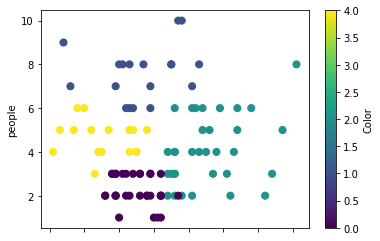

In [12]:
colorsByClusters = {'demo_data__cluster_0':0, 'demo_data__cluster_1': 1, 'demo_data__cluster_2':2,
                    'demo_data__cluster_3':3, 'demo_data__cluster_default':4}

df['Color'] = df['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))

df.plot.scatter(x="avgspend", y ="people", c='Color', colormap='viridis', s = 50)


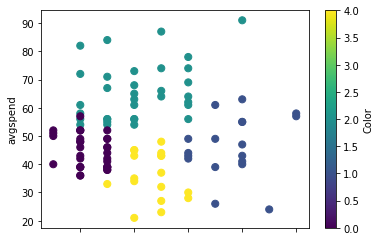

In [13]:
df.plot.scatter(x="people", y ="avgspend", c='Color', colormap='viridis', s = 50)

## Test - 2

**Test of pruning on demo data with min_y = 20[soft bound, hard bound = (20 - 20*0.1)]. 
Mechanism used here, is "MergingCentroids" and through this process we are also looking for "balanced" distribution of data points among the clusters without compromising the qulaity of the clusters.**

In [14]:
df = pd.read_csv('ToDemotestData.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)

In [15]:
df.columns = ['people', 'avgspend']
defaultValues = {'people': 2.0, 'avgspend': 35.0}

In [16]:
clusterTree = __getClusterTreeFromData(df, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=True,
                                       balancedPrune=True, min_y=20, min_split_fraction=0.05,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA_', defaultValues=defaultValues, prevVer=0.0)

attributes, clusters = getAttributesAndClusters(clusterTree)
writePickleFile(path='./DEMO_DATA_ClusterTree_MC_BlP.pickle', data=clusterTree)

2020-04-30 21:16:44,364 - 4585895360 - INFO - read 100
2020-04-30 21:16:44,364 - 4585895360 - INFO - attribute names: [('id', <class 'float'>), ('avgspend', <class 'float'>), ('people', <class 'float'>)]
2020-04-30 21:16:44,365 - 4585895360 - INFO - This is the starting point!
2020-04-30 21:16:44,375 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 8.0
2020-04-30 21:16:44,376 - 4585895360 - INFO - At previous level(0), the cut happened on Attribute:people, Value: 8.0
2020-04-30 21:16:44,385 - 4585895360 - INFO - At this level the best cut is found on Attribute: avgspend, at: 78.0
2020-04-30 21:16:44,386 - 4585895360 - INFO - At previous level(1), the cut happened on Attribute:avgspend, Value: 78.0
2020-04-30 21:16:44,398 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 7.0
2020-04-30 21:16:44,399 - 4585895360 - INFO - At previous level(2), the cut happened on Attribute:people, Value: 7.0
2020-04-30 21:16:44,409 - 458

2020-04-30 21:16:44,539 - 4585895360 - INFO - Level: 20, Datapoints: 
Data: 3
['avgspend', 'people']
 Max :[84. 43.  3.]
 Min :[22. 42.  2.]

--------

2020-04-30 21:16:44,539 - 4585895360 - INFO - Inadequate data points to create further split on right child!
2020-04-30 21:16:44,540 - 4585895360 - INFO - Level: 20, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[81. 46.  3.]
 Min :[ 3. 44.  2.]

--------

2020-04-30 21:16:44,541 - 4585895360 - INFO - At previous level(17), the cut happened on Attribute:avgspend, Value: 46.0
2020-04-30 21:16:44,542 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 2.0
2020-04-30 21:16:44,543 - 4585895360 - INFO - At previous level(18), the cut happened on Attribute:people, Value: 2.0
2020-04-30 21:16:44,544 - 4585895360 - INFO - At this level the best cut is found on Attribute: avgspend, at: 49.0
2020-04-30 21:16:44,545 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21

2020-04-30 21:16:44,594 - 4585895360 - INFO - Min_Y: 18.0, Scenario: dict_values([63, 37]),  #Clusters: 2, argminMetric: 577.2866182104672
2020-04-30 21:16:44,596 - 4585895360 - INFO - Searching for 'min_y'. Current 'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.17006915460820085, 'inter-cluster-distance': 0.37378862301085575, 'purity': 0.4549875093530111, 'varPurity': 4.021303438031479, 'mean-members': 33.333333333333336, 'data-points': {'DEMO_DATA__cluster_0': 23, 'DEMO_DATA__cluster_1': 63, 'DEMO_DATA__cluster_DEFAULT': 14}, 'argminMetric': 4.021303438031479}
2020-04-30 21:16:44,597 - 4585895360 - INFO - Printing MergeList: []
2020-04-30 21:16:44,598 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:16:44,601 - 4585895360 - INFO - Min_Y: 19.0, Scenario: dict_values([23, 63, 14]),  #Clusters: 2.99, argminMetric: 4.021303438031479
2020-04-30 21:16:44,603 - 4585895360 - INFO - Min_Y: 19.0, Scenario: dict_values([63, 37]),  #Clusters: 2, argminMetric: 577.2866182

2020-04-30 21:16:44,694 - 4585895360 - INFO - balancedPrune: True, All argminMetric: {18.0: 4.021303438031479, 19.0: 4.021303438031479, 20.0: 4.021303438031479}
2020-04-30 21:16:44,695 - 4585895360 - INFO - All intermediate stats, generated during grid search: {18.0: {'intra-cluster-distance': 0.17006915460820085, 'inter-cluster-distance': 0.37378862301085575, 'purity': 0.4549875093530111, 'varPurity': 4.021303438031479, 'mean-members': 33.333333333333336, 'data-points': {'DEMO_DATA__cluster_0': 23, 'DEMO_DATA__cluster_1': 63, 'DEMO_DATA__cluster_DEFAULT': 14}, 'argminMetric': 4.021303438031479}, 19.0: {'intra-cluster-distance': 0.17006915460820085, 'inter-cluster-distance': 0.37378862301085575, 'purity': 0.4549875093530111, 'varPurity': 4.021303438031479, 'mean-members': 33.333333333333336, 'data-points': {'DEMO_DATA__cluster_0': 23, 'DEMO_DATA__cluster_1': 63, 'DEMO_DATA__cluster_DEFAULT': 14}, 'argminMetric': 4.021303438031479}, 20.0: {'intra-cluster-distance': 0.17006915460820085, 

True

In [17]:
preds = []
for i in range(len(df)):
    info = dict(df.loc[i])
    pred, _ = clusterTree.getClusterID(info) 
    preds.append(pred)
df['Predicted_Cluster'] = preds

In [18]:
df['Predicted_Cluster'].value_counts()

demo_data__cluster_1          63
demo_data__cluster_0          23
demo_data__cluster_default    14
Name: Predicted_Cluster, dtype: int64

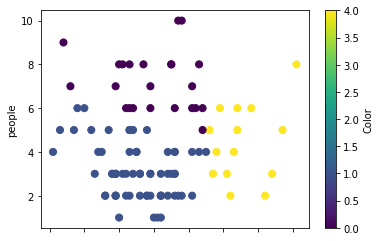

In [19]:
colorsByClusters = {'demo_data__cluster_0':0, 'demo_data__cluster_1': 1, 'demo_data__cluster_2':2,
                    'demo_data__cluster_3':3, 'demo_data__cluster_default':4}

df['Color'] = df['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))
df.plot.scatter(x="avgspend", y ="people", c='Color', colormap='viridis', s = 50)

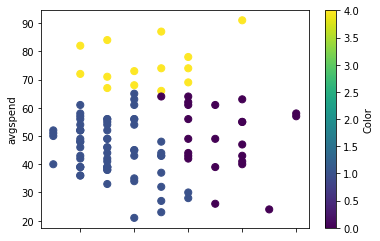

In [20]:
df.plot.scatter(x="people", y ="avgspend", c='Color', colormap='viridis', s = 50)

## Test - 3

**Test of pruning on demo data with min_y = 20[soft bound, hard bound = (20 - 20*0.1)]. 
Mechanism used here, is "ConqueringNodes" with reusing the original data.**

In [21]:
df = pd.read_csv('ToDemotestData.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)

In [22]:
df.columns = ['people', 'avgspend']
defaultValues = {'people': 2.0, 'avgspend': 35.0}

In [23]:
clusterTree = __getClusterTreeFromData(df, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=False,
                                       balancedPrune=False, min_y=20, min_split_fraction=0.05,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA_', defaultValues=defaultValues, prevVer=0.0)

attributes, clusters = getAttributesAndClusters(clusterTree)
writePickleFile(path='./DEMO_DATA_ClusterTree_CnqN_D.pickle', data=clusterTree)

2020-04-30 21:16:46,854 - 4585895360 - INFO - read 100
2020-04-30 21:16:46,855 - 4585895360 - INFO - attribute names: [('id', <class 'float'>), ('avgspend', <class 'float'>), ('people', <class 'float'>)]
2020-04-30 21:16:46,856 - 4585895360 - INFO - This is the starting point!
2020-04-30 21:16:46,866 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 8.0
2020-04-30 21:16:46,867 - 4585895360 - INFO - At previous level(0), the cut happened on Attribute:people, Value: 8.0
2020-04-30 21:16:46,876 - 4585895360 - INFO - At this level the best cut is found on Attribute: avgspend, at: 78.0
2020-04-30 21:16:46,877 - 4585895360 - INFO - At previous level(1), the cut happened on Attribute:avgspend, Value: 78.0
2020-04-30 21:16:46,887 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 7.0
2020-04-30 21:16:46,888 - 4585895360 - INFO - At previous level(2), the cut happened on Attribute:people, Value: 7.0
2020-04-30 21:16:46,897 - 458

2020-04-30 21:16:47,025 - 4585895360 - INFO - Level: 20, Datapoints: 
Data: 3
['avgspend', 'people']
 Max :[84. 43.  3.]
 Min :[22. 42.  2.]

--------

2020-04-30 21:16:47,026 - 4585895360 - INFO - Inadequate data points to create further split on right child!
2020-04-30 21:16:47,027 - 4585895360 - INFO - Level: 20, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[81. 46.  3.]
 Min :[ 3. 44.  2.]

--------

2020-04-30 21:16:47,028 - 4585895360 - INFO - At previous level(17), the cut happened on Attribute:avgspend, Value: 46.0
2020-04-30 21:16:47,029 - 4585895360 - INFO - At this level the best cut is found on Attribute: people, at: 2.0
2020-04-30 21:16:47,030 - 4585895360 - INFO - At previous level(18), the cut happened on Attribute:people, Value: 2.0
2020-04-30 21:16:47,031 - 4585895360 - INFO - At this level the best cut is found on Attribute: avgspend, at: 49.0
2020-04-30 21:16:47,032 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21

2020-04-30 21:16:47,097 - 4585895360 - INFO - Min_Y: 18.0, Scenario: dict_values([46, 40, 14]),  #Clusters: 2.99, Inv-Purity: 0.3121994111284386
2020-04-30 21:16:47,099 - 4585895360 - INFO - Min_Y: 18.0, Scenario: dict_values([40, 60]),  #Clusters: 2, Inv-Purity: 0.4916518490111777
2020-04-30 21:16:47,101 - 4585895360 - INFO - Searching for 'min_y'. Current 'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.13130774179031382, 'inter-cluster-distance': 0.4205893320416736, 'purity': 0.3121994111284386, 'data-points': {'DEMO_DATA__cluster_0': 46, 'DEMO_DATA__cluster_1': 40, 'DEMO_DATA__cluster_DEFAULT': 14}}
2020-04-30 21:16:47,102 - 4585895360 - INFO - Printing MergeList: []
2020-04-30 21:16:47,103 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:16:47,122 - 4585895360 - INFO - Min_Y: 19.0, Scenario: dict_values([46, 40, 14]),  #Clusters: 2.99, Inv-Purity: 0.3121994111284386
2020-04-30 21:16:47,124 - 4585895360 - INFO - Min_Y: 19.0, Scenario: dict_values([40, 60]),  

2020-04-30 21:16:47,323 - 4585895360 - INFO - Printing MergeList: []
2020-04-30 21:16:47,324 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:16:47,344 - 4585895360 - INFO - Min_Y: 18.0, Scenario: dict_values([46, 40, 14]),  #Clusters: 2.99, Inv-Purity: 0.3121994111284386
2020-04-30 21:16:47,345 - 4585895360 - INFO - Min_Y: 18.0, Scenario: dict_values([40, 60]),  #Clusters: 2, Inv-Purity: 0.4916518490111777
2020-04-30 21:16:47,347 - 4585895360 - INFO - Search Mode: False.        Note: The underlying Tree structure got modified in the process of pruning to make the search space optimized!        'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.13130774179031382, 'inter-cluster-distance': 0.4205893320416736, 'purity': 0.3121994111284386, 'data-points': {'DEMO_DATA__cluster_0': 46, 'DEMO_DATA__cluster_1': 40, 'DEMO_DATA__cluster_DEFAULT': 14}}


True

In [24]:
preds = []
for i in range(len(df)):
    info = dict(df.loc[i])
    pred, _ = clusterTree.getClusterID(info) 
    preds.append(pred)
df['Predicted_Cluster'] = preds

In [25]:
df['Predicted_Cluster'].value_counts()

demo_data__cluster_0          46
demo_data__cluster_1          40
demo_data__cluster_default    14
Name: Predicted_Cluster, dtype: int64

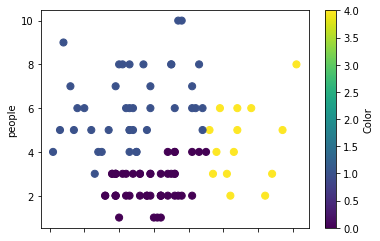

In [26]:
colorsByClusters = {'demo_data__cluster_0':0, 'demo_data__cluster_1': 1, 'demo_data__cluster_2':2,
                    'demo_data__cluster_3':3, 'demo_data__cluster_default':4}

df['Color'] = df['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))
df.plot.scatter(x="avgspend", y ="people", c='Color', colormap='viridis', s = 50)

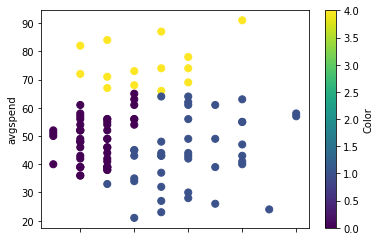

In [27]:
df.plot.scatter(x="people", y ="avgspend", c='Color', colormap='viridis', s = 50)

In [28]:
from sklearn.datasets import make_blobs
import pandas as pd
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 

In [29]:
set(y)

{0, 1, 2, 3}

In [30]:
df3=pd.DataFrame(X)

In [31]:
df3 = df3.round(2)

In [32]:
df3.columns = ['col1', 'col2']
defaultValues = {'col1': -6.0, 'col2': -2.66}

In [33]:
clusterTree3 = __getClusterTreeFromData(df3, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=True,
                                       balancedPrune=False, min_y=100, min_split_fraction=0.01,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA2_', defaultValues=defaultValues, prevVer=0.0)

attributes, clusters = getAttributesAndClusters(clusterTree3)
writePickleFile(path='./DEMO_DATA2_ClusterTree.pickle', data=clusterTree3)

2020-04-30 21:16:53,089 - 4585895360 - INFO - read 500
2020-04-30 21:16:53,090 - 4585895360 - INFO - attribute names: [('id', <class 'float'>), ('col2', <class 'float'>), ('col1', <class 'float'>)]
2020-04-30 21:16:53,090 - 4585895360 - INFO - This is the starting point!
2020-04-30 21:16:53,193 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -12.5
2020-04-30 21:16:53,194 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:53,194 - 4585895360 - INFO - Level: 1, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[ 57.    -6.07 -12.5 ]
 Min :[ 57.    -6.07 -12.5 ]

--------

2020-04-30 21:16:53,195 - 4585895360 - INFO - At previous level(0), the cut happened on Attribute:col1, Value: -12.5
2020-04-30 21:16:53,286 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -10.94
2020-04-30 21:16:53,287 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04

2020-04-30 21:16:54,591 - 4585895360 - INFO - At previous level(15), the cut happened on Attribute:col2, Value: -10.67
2020-04-30 21:16:54,691 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -11.11
2020-04-30 21:16:54,692 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:54,693 - 4585895360 - INFO - Level: 17, Datapoints: 
Data: 2
['col2', 'col1']
 Max :[440.    -3.87 -11.11]
 Min :[ 68.    -3.97 -11.11]

--------

2020-04-30 21:16:54,694 - 4585895360 - INFO - At previous level(16), the cut happened on Attribute:col1, Value: -11.11
2020-04-30 21:16:54,795 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -11.02
2020-04-30 21:16:54,796 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:54,797 - 4585895360 - INFO - Level: 18, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[ 21.    -3.16 -11.02]
 Min :[ 21.    -3.16 -11.02]

--

2020-04-30 21:16:56,263 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:56,263 - 4585895360 - INFO - Level: 33, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[428.    -3.01 -10.56]
 Min :[428.    -3.01 -10.56]

--------

2020-04-30 21:16:56,264 - 4585895360 - INFO - At previous level(32), the cut happened on Attribute:col1, Value: -10.56
2020-04-30 21:16:56,361 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -10.53
2020-04-30 21:16:56,362 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:56,363 - 4585895360 - INFO - Level: 34, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[418.    -2.84 -10.53]
 Min :[418.    -2.84 -10.53]

--------

2020-04-30 21:16:56,363 - 4585895360 - INFO - At previous level(33), the cut happened on Attribute:col1, Value: -10.53
2020-04-30 21:16:56,461 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at:

2020-04-30 21:16:57,839 - 4585895360 - INFO - At previous level(48), the cut happened on Attribute:col1, Value: -10.2
2020-04-30 21:16:57,935 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -10.19
2020-04-30 21:16:57,936 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:57,937 - 4585895360 - INFO - Level: 50, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[344.    -3.15 -10.19]
 Min :[344.    -3.15 -10.19]

--------

2020-04-30 21:16:57,937 - 4585895360 - INFO - At previous level(49), the cut happened on Attribute:col1, Value: -10.19
2020-04-30 21:16:58,030 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -10.18
2020-04-30 21:16:58,031 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:58,032 - 4585895360 - INFO - Level: 51, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[ 85.    -4.01 -10.18]
 Min :[ 85.    -4.01 -10.18]

---

2020-04-30 21:16:59,132 - 4585895360 - INFO - At previous level(65), the cut happened on Attribute:col2, Value: -9.49
2020-04-30 21:16:59,178 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -9.37
2020-04-30 21:16:59,179 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:59,180 - 4585895360 - INFO - Level: 67, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[183.    -9.37  -9.76]
 Min :[183.    -9.37  -9.76]

--------

2020-04-30 21:16:59,180 - 4585895360 - INFO - At previous level(66), the cut happened on Attribute:col2, Value: -9.37
2020-04-30 21:16:59,226 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -9.32
2020-04-30 21:16:59,227 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:59,228 - 4585895360 - INFO - Level: 68, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[439.    -9.32  -6.9 ]
 Min :[439.    -9.32  -6.9 ]

------

2020-04-30 21:16:59,944 - 4585895360 - INFO - At previous level(82), the cut happened on Attribute:col1, Value: -9.89
2020-04-30 21:16:59,987 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -9.86
2020-04-30 21:16:59,988 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:16:59,989 - 4585895360 - INFO - Level: 84, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[270.    -2.75  -9.86]
 Min :[270.    -2.75  -9.86]

--------

2020-04-30 21:16:59,989 - 4585895360 - INFO - At previous level(83), the cut happened on Attribute:col1, Value: -9.86
2020-04-30 21:17:00,033 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -9.84
2020-04-30 21:17:00,034 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:00,035 - 4585895360 - INFO - Level: 85, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[159.    -4.14  -9.84]
 Min :[159.    -4.14  -9.84]

------

2020-04-30 21:17:00,690 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:00,691 - 4585895360 - INFO - Level: 100, Datapoints: 
Data: 3
['col2', 'col1']
 Max :[256.    -3.    -9.38]
 Min :[39.   -4.55 -9.38]

--------

2020-04-30 21:17:00,692 - 4585895360 - INFO - At previous level(99), the cut happened on Attribute:col1, Value: -9.38
2020-04-30 21:17:00,732 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -9.34
2020-04-30 21:17:00,733 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:00,733 - 4585895360 - INFO - Level: 101, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[156.    -4.    -9.34]
 Min :[156.    -4.    -9.34]

--------

2020-04-30 21:17:00,734 - 4585895360 - INFO - At previous level(100), the cut happened on Attribute:col1, Value: -9.34
2020-04-30 21:17:00,773 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -9

2020-04-30 21:17:01,334 - 4585895360 - INFO - At previous level(115), the cut happened on Attribute:col1, Value: -8.9
2020-04-30 21:17:01,372 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -8.87
2020-04-30 21:17:01,373 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:01,374 - 4585895360 - INFO - Level: 117, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[62.   -3.65 -8.87]
 Min :[62.   -3.65 -8.87]

--------

2020-04-30 21:17:01,374 - 4585895360 - INFO - At previous level(116), the cut happened on Attribute:col1, Value: -8.87
2020-04-30 21:17:01,411 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -8.85
2020-04-30 21:17:01,412 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:01,413 - 4585895360 - INFO - Level: 118, Datapoints: 
Data: 2
['col2', 'col1']
 Max :[141.    -4.    -8.85]
 Min :[89.   -7.79 -8.85]

--------

20

2020-04-30 21:17:01,959 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:01,960 - 4585895360 - INFO - Level: 133, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[385.    -5.65  -8.26]
 Min :[385.    -5.65  -8.26]

--------

2020-04-30 21:17:01,960 - 4585895360 - INFO - At previous level(132), the cut happened on Attribute:col1, Value: -8.26
2020-04-30 21:17:01,993 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -8.25
2020-04-30 21:17:01,994 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:01,995 - 4585895360 - INFO - Level: 134, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[17.   -8.61 -8.25]
 Min :[17.   -8.61 -8.25]

--------

2020-04-30 21:17:01,995 - 4585895360 - INFO - At previous level(133), the cut happened on Attribute:col1, Value: -8.25
2020-04-30 21:17:02,027 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -8.2

2020-04-30 21:17:02,492 - 4585895360 - INFO - At previous level(148), the cut happened on Attribute:col1, Value: -7.87
2020-04-30 21:17:02,524 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -7.86
2020-04-30 21:17:02,525 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:02,526 - 4585895360 - INFO - Level: 150, Datapoints: 
Data: 2
['col2', 'col1']
 Max :[388.    -4.74  -7.86]
 Min :[305.    -6.93  -7.86]

--------

2020-04-30 21:17:02,526 - 4585895360 - INFO - At previous level(149), the cut happened on Attribute:col1, Value: -7.86
2020-04-30 21:17:02,555 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -7.83
2020-04-30 21:17:02,556 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:02,557 - 4585895360 - INFO - Level: 151, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[495.    -2.51  -7.83]
 Min :[495.    -2.51  -7.83]

--

2020-04-30 21:17:03,022 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:03,022 - 4585895360 - INFO - Level: 166, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[370.    -8.28  -7.33]
 Min :[370.    -8.28  -7.33]

--------

2020-04-30 21:17:03,023 - 4585895360 - INFO - At previous level(165), the cut happened on Attribute:col1, Value: -7.33
2020-04-30 21:17:03,047 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -7.32
2020-04-30 21:17:03,048 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:03,049 - 4585895360 - INFO - Level: 167, Datapoints: 
Data: 3
['col2', 'col1']
 Max :[413.    -2.73  -7.32]
 Min :[59.   -7.96 -7.32]

--------

2020-04-30 21:17:03,050 - 4585895360 - INFO - At previous level(166), the cut happened on Attribute:col1, Value: -7.32
2020-04-30 21:17:03,083 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -

2020-04-30 21:17:03,504 - 4585895360 - INFO - At previous level(181), the cut happened on Attribute:col2, Value: -8.82
2020-04-30 21:17:03,534 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -8.78
2020-04-30 21:17:03,534 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:03,535 - 4585895360 - INFO - Level: 183, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[369.    -8.78  -6.28]
 Min :[369.    -8.78  -6.28]

--------

2020-04-30 21:17:03,536 - 4585895360 - INFO - At previous level(182), the cut happened on Attribute:col2, Value: -8.78
2020-04-30 21:17:03,563 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -8.77
2020-04-30 21:17:03,564 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:03,564 - 4585895360 - INFO - Level: 184, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[321.    -8.77  -6.25]
 Min :[321.    -8.77  -6.25]

--

2020-04-30 21:17:03,978 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:03,979 - 4585895360 - INFO - Level: 199, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[221.    -7.64  -6.92]
 Min :[221.    -7.64  -6.92]

--------

2020-04-30 21:17:03,980 - 4585895360 - INFO - At previous level(198), the cut happened on Attribute:col1, Value: -6.92
2020-04-30 21:17:04,003 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -6.91
2020-04-30 21:17:04,003 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:04,004 - 4585895360 - INFO - Level: 200, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[237.    -7.69  -6.91]
 Min :[237.    -7.69  -6.91]

--------

2020-04-30 21:17:04,005 - 4585895360 - INFO - At previous level(199), the cut happened on Attribute:col1, Value: -6.91
2020-04-30 21:17:04,029 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at

2020-04-30 21:17:04,368 - 4585895360 - INFO - At previous level(214), the cut happened on Attribute:col1, Value: -6.6
2020-04-30 21:17:04,387 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -6.59
2020-04-30 21:17:04,388 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:04,389 - 4585895360 - INFO - Level: 216, Datapoints: 
Data: 2
['col2', 'col1']
 Max :[444.    -2.45  -6.59]
 Min :[25.   -4.43 -6.59]

--------

2020-04-30 21:17:04,389 - 4585895360 - INFO - At previous level(215), the cut happened on Attribute:col1, Value: -6.59
2020-04-30 21:17:04,410 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -6.56
2020-04-30 21:17:04,411 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:04,411 - 4585895360 - INFO - Level: 217, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[461.    -3.96  -6.56]
 Min :[461.    -3.96  -6.56]

------

2020-04-30 21:17:04,682 - 4585895360 - INFO - At previous level(231), the cut happened on Attribute:col1, Value: -6.21
2020-04-30 21:17:04,686 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -6.92
2020-04-30 21:17:04,687 - 4585895360 - INFO - At previous level(232), the cut happened on Attribute:col2, Value: -6.92
2020-04-30 21:17:04,690 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -6.18
2020-04-30 21:17:04,691 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:04,692 - 4585895360 - INFO - Level: 234, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[230.    -7.96  -6.18]
 Min :[230.    -7.96  -6.18]

--------

2020-04-30 21:17:04,693 - 4585895360 - INFO - At previous level(233), the cut happened on Attribute:col1, Value: -6.18
2020-04-30 21:17:04,696 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -8.19
2020-04-30 21:17:04,697 - 45858953

2020-04-30 21:17:04,824 - 4585895360 - INFO - At previous level(235), the cut happened on Attribute:col2, Value: -4.48
2020-04-30 21:17:04,835 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -4.32
2020-04-30 21:17:04,835 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:04,836 - 4585895360 - INFO - Level: 237, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[22.   -4.32 -5.17]
 Min :[22.   -4.32 -5.17]

--------

2020-04-30 21:17:04,837 - 4585895360 - INFO - At previous level(236), the cut happened on Attribute:col2, Value: -4.32
2020-04-30 21:17:04,847 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -4.22
2020-04-30 21:17:04,848 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:04,848 - 4585895360 - INFO - Level: 238, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[209.    -4.22  -5.05]
 Min :[209.    -4.22  -5.05]

--------

2020-04-30 21:17:05,009 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,010 - 4585895360 - INFO - Level: 253, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[265.    -3.11  -6.16]
 Min :[265.    -3.11  -6.16]

--------

2020-04-30 21:17:05,010 - 4585895360 - INFO - At previous level(252), the cut happened on Attribute:col1, Value: -6.16
2020-04-30 21:17:05,018 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -6.14
2020-04-30 21:17:05,019 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,020 - 4585895360 - INFO - Level: 254, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[366.    -3.65  -6.14]
 Min :[366.    -3.65  -6.14]

--------

2020-04-30 21:17:05,020 - 4585895360 - INFO - At previous level(253), the cut happened on Attribute:col1, Value: -6.14
2020-04-30 21:17:05,028 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at

2020-04-30 21:17:05,143 - 4585895360 - INFO - At previous level(268), the cut happened on Attribute:col2, Value: -3.32
2020-04-30 21:17:05,148 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -3.31
2020-04-30 21:17:05,149 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,150 - 4585895360 - INFO - Level: 270, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[215.    -3.31  -5.12]
 Min :[215.    -3.31  -5.12]

--------

2020-04-30 21:17:05,150 - 4585895360 - INFO - At previous level(269), the cut happened on Attribute:col2, Value: -3.31
2020-04-30 21:17:05,156 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -3.3
2020-04-30 21:17:05,156 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,157 - 4585895360 - INFO - Level: 271, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[449.    -3.3   -5.21]
 Min :[449.    -3.3   -5.21]

---

2020-04-30 21:17:05,279 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -4.24
2020-04-30 21:17:05,281 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,281 - 4585895360 - INFO - Level: 60, Datapoints: 
Data: 2
['col2', 'col1']
 Max :[383.    -4.24  -3.74]
 Min :[333.    -8.75  -4.74]

--------

2020-04-30 21:17:05,282 - 4585895360 - INFO - At previous level(59), the cut happened on Attribute:col2, Value: -4.24
2020-04-30 21:17:05,311 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 1.97
2020-04-30 21:17:05,312 - 4585895360 - INFO - At previous level(60), the cut happened on Attribute:col2, Value: 1.97
2020-04-30 21:17:05,314 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: -1.67
2020-04-30 21:17:05,315 - 4585895360 - INFO - At previous level(61), the cut happened on Attribute:col2, Value: -1.67
2020-04-30 21:17:05,317 - 4585895360 - I

2020-04-30 21:17:05,595 - 4585895360 - INFO - Level: 72, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[322.    3.9  -3.1]
 Min :[322.    3.9  -3.1]

--------

2020-04-30 21:17:05,595 - 4585895360 - INFO - At previous level(71), the cut happened on Attribute:col1, Value: -3.1
2020-04-30 21:17:05,614 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -3.03
2020-04-30 21:17:05,615 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,616 - 4585895360 - INFO - Level: 73, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[326.     4.72  -3.03]
 Min :[326.     4.72  -3.03]

--------

2020-04-30 21:17:05,616 - 4585895360 - INFO - At previous level(72), the cut happened on Attribute:col1, Value: -3.03
2020-04-30 21:17:05,634 - 4585895360 - INFO - At this level the best cut is found on Attribute: col1, at: -2.93
2020-04-30 21:17:05,635 - 4585895360 - INFO - Inadequate data points to create further split on left child!
202

2020-04-30 21:17:05,965 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 3.41
2020-04-30 21:17:05,966 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,967 - 4585895360 - INFO - Level: 89, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[314.     3.41  -2.18]
 Min :[314.     3.41  -2.18]

--------

2020-04-30 21:17:05,967 - 4585895360 - INFO - At previous level(88), the cut happened on Attribute:col2, Value: 3.41
2020-04-30 21:17:05,986 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 3.45
2020-04-30 21:17:05,987 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:05,988 - 4585895360 - INFO - Level: 90, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[27.    3.45 -0.92]
 Min :[27.    3.45 -0.92]

--------

2020-04-30 21:17:05,988 - 4585895360 - INFO - At previous level(89), the cut happened on Attribute:col2, Value: 3.45
2020-0

2020-04-30 21:17:06,257 - 4585895360 - INFO - Level: 105, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[415.     3.97  -1.04]
 Min :[415.     3.97  -1.04]

--------

2020-04-30 21:17:06,257 - 4585895360 - INFO - At previous level(104), the cut happened on Attribute:col2, Value: 3.97
2020-04-30 21:17:06,274 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 4.01
2020-04-30 21:17:06,275 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:06,276 - 4585895360 - INFO - Level: 106, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[195.     4.01  -2.35]
 Min :[195.     4.01  -2.35]

--------

2020-04-30 21:17:06,276 - 4585895360 - INFO - At previous level(105), the cut happened on Attribute:col2, Value: 4.01
2020-04-30 21:17:06,293 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 4.02
2020-04-30 21:17:06,294 - 4585895360 - INFO - Inadequate data points to create further split on left chi

2020-04-30 21:17:06,498 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 4.39
2020-04-30 21:17:06,498 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:06,499 - 4585895360 - INFO - Level: 122, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[114.     4.39  -2.33]
 Min :[114.     4.39  -2.33]

--------

2020-04-30 21:17:06,499 - 4585895360 - INFO - At previous level(121), the cut happened on Attribute:col2, Value: 4.39
2020-04-30 21:17:06,509 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 4.44
2020-04-30 21:17:06,510 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:06,510 - 4585895360 - INFO - Level: 123, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[331.     4.44  -1.93]
 Min :[331.     4.44  -1.93]

--------

2020-04-30 21:17:06,511 - 4585895360 - INFO - At previous level(122), the cut happened on Attribute:col2, Value: 4

2020-04-30 21:17:06,672 - 4585895360 - INFO - Level: 138, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[104.     5.08  -2.52]
 Min :[104.     5.08  -2.52]

--------

2020-04-30 21:17:06,672 - 4585895360 - INFO - At previous level(137), the cut happened on Attribute:col1, Value: -2.52
2020-04-30 21:17:06,679 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 4.78
2020-04-30 21:17:06,680 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:06,681 - 4585895360 - INFO - Level: 139, Datapoints: 
Data: 2
['col2', 'col1']
 Max :[118.     4.78  -0.5 ]
 Min :[112.     4.78  -2.33]

--------

2020-04-30 21:17:06,681 - 4585895360 - INFO - At previous level(138), the cut happened on Attribute:col2, Value: 4.78
2020-04-30 21:17:06,688 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 4.82
2020-04-30 21:17:06,689 - 4585895360 - INFO - Inadequate data points to create further split on left ch

2020-04-30 21:17:06,792 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 5.31
2020-04-30 21:17:06,793 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:06,793 - 4585895360 - INFO - Level: 155, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[ 3.    5.31 -2.31]
 Min :[ 3.    5.31 -2.31]

--------

2020-04-30 21:17:06,794 - 4585895360 - INFO - At previous level(154), the cut happened on Attribute:col2, Value: 5.31
2020-04-30 21:17:06,797 - 4585895360 - INFO - At this level the best cut is found on Attribute: col2, at: 5.34
2020-04-30 21:17:06,798 - 4585895360 - INFO - Inadequate data points to create further split on left child!
2020-04-30 21:17:06,798 - 4585895360 - INFO - Level: 156, Datapoints: 
Data: 1
['col2', 'col1']
 Max :[479.     5.34  -0.82]
 Min :[479.     5.34  -0.82]

--------

2020-04-30 21:17:06,799 - 4585895360 - INFO - At previous level(155), the cut happened on Attribute:col2, Value: 5.34
20

2020-04-30 21:17:07,728 - 4585895360 - INFO - Printing MergeList: []
2020-04-30 21:17:07,728 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:17:07,788 - 4585895360 - INFO - Min_Y: 94.0, Scenario: dict_values([112, 125, 132, 131]),  #Clusters: 4, argminMetric: 0.17657131280648353
2020-04-30 21:17:07,815 - 4585895360 - INFO - Min_Y: 94.0, Scenario: dict_values([125, 132, 243]),  #Clusters: 3, argminMetric: 0.3439067426642976
2020-04-30 21:17:07,847 - 4585895360 - INFO - Min_Y: 94.0, Scenario: dict_values([125, 375]),  #Clusters: 2, argminMetric: 5.558979125655732
2020-04-30 21:17:07,859 - 4585895360 - INFO - Searching for 'min_y'. Current 'min_y' = 94.0, 'result' = 
{'intra-cluster-distance': 0.09581478271159552, 'inter-cluster-distance': 0.5426407109325025, 'purity': 0.17657131280648353, 'varPurity': 1.4426436274239238, 'mean-members': 125.0, 'data-points': {'DEMO_DATA2__cluster_0': 112, 'DEMO_DATA2__cluster_1': 125, 'DEMO_DATA2__cluster_2': 132, 'DEMO_DATA2__cluster_3':

2020-04-30 21:17:09,504 - 4585895360 - INFO - Printing MergeList: []
2020-04-30 21:17:09,505 - 4585895360 - INFO - Printing Touching Nodes: {}
2020-04-30 21:17:09,565 - 4585895360 - INFO - Min_Y: 90.0, Scenario: dict_values([112, 125, 132, 131]),  #Clusters: 4, argminMetric: 0.17657131280648353
2020-04-30 21:17:09,591 - 4585895360 - INFO - Min_Y: 90.0, Scenario: dict_values([125, 132, 243]),  #Clusters: 3, argminMetric: 0.3439067426642976
2020-04-30 21:17:09,623 - 4585895360 - INFO - Min_Y: 90.0, Scenario: dict_values([125, 375]),  #Clusters: 2, argminMetric: 5.558979125655732
2020-04-30 21:17:09,648 - 4585895360 - INFO - Search Mode: False.            Note: The underlying Tree structure got modified in the process of pruning to make the search space optimized!            'min_y' = 90.0, 'result' = 
{'intra-cluster-distance': 0.09581478271159552, 'inter-cluster-distance': 0.5426407109325025, 'purity': 0.17657131280648353, 'varPurity': 1.4426436274239238, 'mean-members': 125.0, 'data-po

True

In [34]:
clusterTree3.attributeToDataType

{'col1': (int, float), 'col2': (int, float)}

In [35]:
clusterTree3.defaultVals

{'col1': -6.0, 'col2': -2.66}

In [36]:
print(attributes)
clusters

{'col1', 'col2'}


{'demo_data2__cluster_0',
 'demo_data2__cluster_1',
 'demo_data2__cluster_2',
 'demo_data2__cluster_3'}

In [37]:
preds2 = []
for i in range(len(df3)):
    info = dict(df3.loc[i])
    pred2, _ = clusterTree3.getClusterID(info) 
    preds2.append(pred2)
df3['Predicted_Cluster'] = preds2

In [38]:
df3['Predicted_Cluster'].value_counts()

demo_data2__cluster_2    132
demo_data2__cluster_3    131
demo_data2__cluster_1    125
demo_data2__cluster_0    112
Name: Predicted_Cluster, dtype: int64

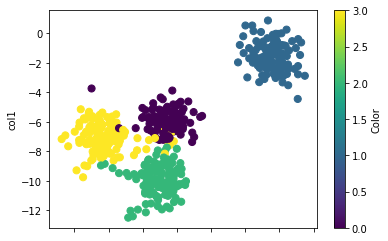

In [39]:
colorsByClusters = {'demo_data2__cluster_0':0, 'demo_data2__cluster_1': 1, 'demo_data2__cluster_2':2,
                    'demo_data2__cluster_3':3, 'demo_data2__cluster_default':4}

df3['Color'] = df3['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))

df3.plot.scatter(x="col2", y ="col1", c='Color', colormap='viridis', s = 50)


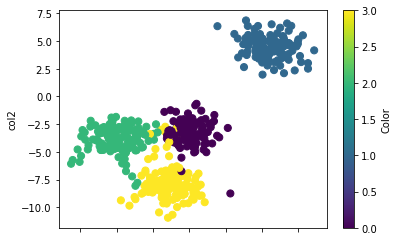

In [40]:
df3.plot.scatter(x="col1", y ="col2", c='Color', colormap='viridis', s = 50)